In [67]:
import networkx as nx
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_dict_from_csv(filepath):
    '''
    Loads networks components from csv file back into a nested dict

    Inputs:
    - filepath: string path to csv file
        - columns: 'Pathway', 'Reactions', 'Substrates', 'Products'

    Output:
    - network_components: nested dict of the form {'Pathway': {'Reactions': (Substrates, Products)}}
    '''

    network_components = {}

    with open(filepath, mode='r') as file:
        reader = csv.DictReader(file)

        for row in reader:
            pathway_desc = row['Pathway']
            reaction = row['Reactions']
            substrates = row['Substrates'].split(',')
            products = row['Products'].split(',')

            if pathway_desc not in network_components:
                network_components[pathway_desc] = {}

            network_components[pathway_desc][reaction] = (substrates, products)

    return network_components

In [3]:
def create_metabolic_network(network_components):
    '''
    Creates a bipartitie network from the KEGG pathway data
    substrate(metabolite) --> reaction --> product(metabolite)

    Inputs:
    - network_components: nested dict of the form {'Pathway': {'Reactions': (Substrates, Products)}}

    Output:
    - G: NetworkX graph object representing the bipartite network
    - pathway_tags: dictionary mapping nodes to their pathway descriptions
    '''

    G = nx.Graph() # create an empty bipartite graph

    for pathway_description, reactions in network_components.items():
        for reaction, (substrates, products) in reactions.items():
            # add reaction node and tag it with pathway description
            G.add_node(reaction, bipartite=0, node_type='reaction', pathway=pathway_description)
            
            # add substrate nodes and create edges to the reaction node
            for substrate in substrates:
                G.add_node(substrate, bipartite=1, node_type='metabolite', pathway=pathway_description)
                G.add_edge(substrate, reaction)

            # add product nodes and create edges from the reaction node
            for product in products:
                G.add_node(product, bipartite=1, node_type='metabolite', pathway=pathway_description)
                G.add_edge(product, reaction)

    return G

In [4]:
def filter_network(G, network_components):
    # Find the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    
    # Filter the pathways_dict based on nodes in the largest connected component
    filtered_pathways_dict = {}
    
    for pathway_description, reactions in network_components.items():
        filtered_reactions = {}
        for reaction, (substrates, products) in reactions.items():
            # Check if the reaction and all related substrates/products are in the largest component
            if reaction in largest_cc and all(sub in largest_cc for sub in substrates) and all(prod in largest_cc for prod in products):
                filtered_reactions[reaction] = (substrates, products)
        
        if filtered_reactions:
            filtered_pathways_dict[pathway_description] = filtered_reactions
    
    return filtered_pathways_dict

In [7]:
# get dictionary of network components
network_components = load_dict_from_csv('metpath_data/bsu_metpathways_data.csv')

# create network
G = create_metabolic_network(network_components)

# filter dictionary based on largest connected component
filtered_network_components = filter_network(G, network_components)

# create filtered network
G_filtered = create_metabolic_network(filtered_network_components)

In [9]:
# get single pathway for testing
test_network_components = {"Carbon metabolism": filtered_network_components['Carbon metabolism']}

In [11]:
for i in test_network_components['Carbon metabolism']:
    print(i)
    print(test_network_components['Carbon metabolism'][i])
    print()

rn:R01518
(['cpd:C00631'], ['cpd:C00197'])

rn:R01512
(['cpd:C00197'], ['cpd:C00236'])

rn:R01061
(['cpd:C00118'], ['cpd:C00236'])

rn:R01068
(['cpd:C00354'], ['cpd:C00118', ' cpd:C00111'])

rn:R00762
(['cpd:C00354'], ['cpd:C00085'])

rn:R01067
(['cpd:C00118', ' cpd:C00085'], ['cpd:C00231', ' cpd:C00279'])

rn:R01829
(['cpd:C00111', ' cpd:C00279'], ['cpd:C00447'])

rn:R01641
(['cpd:C00118', ' cpd:C05382'], ['cpd:C00231', ' cpd:C00117'])

rn:R01529
(['cpd:C00199'], ['cpd:C00231'])

rn:R00756
(['cpd:C00085'], ['cpd:C00354'])

rn:R01786
(['cpd:C00267 cpd:C00221'], ['cpd:C00668 cpd:C01172'])

rn:R13199
(['cpd:C00668 cpd:C01172'], ['cpd:C00085'])

rn:R02736
(['cpd:C00668 cpd:C01172'], ['cpd:C01236'])

rn:R02035
(['cpd:C01236'], ['cpd:C00345'])

rn:R01528
(['cpd:C00345'], ['cpd:C00199'])

rn:R01056
(['cpd:C00117'], ['cpd:C00199'])

rn:R01015
(['cpd:C00118'], ['cpd:C00111'])

rn:R08575
(['cpd:C00118', ' cpd:C05382'], ['cpd:C00279', ' cpd:C00085'])

rn:R00658
(['cpd:C00631'], ['cpd:C00074'])



In [59]:
def get_node_metrics(G, organism_code):
    '''
    Calculates and writes node metrics to a csv file

    Inputs:
    - G: NetworkX graph object
    - output_file: string path to output csv file
    '''

    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    pathway_attr = nx.get_node_attributes(G, 'pathway')

    node_type = []
    for node in G.nodes():
        if 'rn' in node:
            node_type.append('reaction')
        elif 'cpd' in node:
            node_type.append('metabolite')
        else:
            node_type.append("unknown")


    # create dataframe to store information
    metrics_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Organism': organism_code,
        'Type': node_type,
        'Pathway': [pathway_attr.get(node, None) for node in G.nodes()],
        'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
        'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
        'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
        'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()]
    })


    return metrics_df

In [37]:
def load_metrics(filepath):
    # file path is './metrics/organismcode_node_metrics.csv' or './metrics/organismcode_network_metrics.csv'
    return pd.read_csv(filepath)

In [58]:
def get_network_metrics(G, organism_code):
    # calculate metrics
    clustering_coefficient = nx.average_clustering(G)
    avg_path_length = nx.average_shortest_path_length(G)
    density = nx.density(G)
    num_nodes = G.number_of_nodes()

    # create dataframe to store information
    metrics_df = pd.DataFrame(
        columns = ['Organism','Clustering Coefficient', 'Average Path Length', 'Density', 'Number of Nodes'],
        data=[[organism_code, clustering_coefficient, avg_path_length, density, num_nodes]]
    )

    return metrics_df

In [40]:
df = get_node_metrics(G_filtered, 'bsu')
df.head()

,Node,Organism,Type,Pathway,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,rn:R00342,bsu,reaction,Carbon metabolism,0.001587,0.003622,0.065796,0.004728
1,cpd:C00149,bsu,metabolite,Carbon metabolism,0.004762,0.046467,0.067297,0.010893
2,cpd:C00036,bsu,metabolite,Biosynthesis of amino acids,0.004762,0.126764,0.067118,0.011269
3,rn:R00351,bsu,reaction,Biosynthesis of amino acids,0.003968,0.077696,0.067093,0.009143
4,cpd:C00024,bsu,metabolite,Degradation of aromatic compounds,0.007937,0.248217,0.068691,0.016373


In [51]:
net_df = get_network_metrics(G_filtered, 'bsu')
net_df.head()

,Organism,Clustering Coefficient,Average Path Length,Density,Number of Nodes
0,bsu,0.0,24.992221,0.001775,1261


# calculate metrics for all organisms

In [54]:
organism_list = ['eco','bsu', 'sau', 'mtu', 'pae', 'sen', 'hpy', 'lba', 'spn', 'cdi']


In [33]:
organism_code = 'eco'
pathway_data_path = f"metpath_data/{organism_code}_metpathways_data.csv"

# unfiltered network components
network_components = load_dict_from_csv(pathway_data_path)
G_unfiltered = create_metabolic_network(network_components)

# filtered network
filtered_network_components = filter_network(G_unfiltered, network_components)
G_filtered = create_metabolic_network(filtered_network_components)

In [60]:
def get_overall_metrics(organism_list):

    network_metrics = pd.DataFrame(
        columns = ['Organism','Clustering Coefficient', 'Average Path Length', 'Density', 'Number of Nodes']
    )
    node_metrics = pd.DataFrame(
        columns = ['Node', 'Organism', 'Type', 'Pathway', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']
    )


    for org in organism_list:
        pathway_data_path = f"metpath_data/{org}_metpathways_data.csv"

        # unfiltered network components
        network_components = load_dict_from_csv(pathway_data_path)
        G_unfiltered = create_metabolic_network(network_components)

        # filtered network
        filtered_network_components = filter_network(G_unfiltered, network_components)
        G_filtered = create_metabolic_network(filtered_network_components)

        # get node metrics
        node_metrics_df = get_node_metrics(G_filtered, org)

        # get network metrics
        network_metrics_df = get_network_metrics(G_filtered, org)

        network_metrics = pd.concat([network_metrics, network_metrics_df])
        node_metrics = pd.concat([node_metrics, node_metrics_df])

    network_metrics.to_csv('metrics/overall_network_metrics.csv', index=False)
    node_metrics.to_csv('metrics/overall_node_metrics.csv', index=False)

    return network_metrics, node_metrics



In [143]:
def get_individual_network_metrics(G, organism_code, pathway):
    # calculate metrics
    clustering_coefficient = nx.average_clustering(G)
    avg_path_length = nx.average_shortest_path_length(G)
    density = nx.density(G)
    num_nodes = G.number_of_nodes()

    # create dataframe to store information
    metrics_df = pd.DataFrame(
        columns = ['Organism','Pathway','Clustering Coefficient', 'Average Path Length', 'Density', 'Number of Nodes'],
        data=[[organism_code, pathway, clustering_coefficient, avg_path_length, density, num_nodes]]
    )

    return metrics_df

In [147]:
def get_individual_metrics(organism_list):

    network_metrics = pd.DataFrame(
        columns = ['Organism', 'Pathway','Clustering Coefficient', 'Average Path Length', 'Density', 'Number of Nodes']
    )

    for org in organism_list:
        pathway_data_path = f"metpath_data/{org}_metpathways_data.csv"

        # unfiltered network components
        network_components = load_dict_from_csv(pathway_data_path)
        # G_unfiltered = create_metabolic_network(network_components)

        for i in network_components:
            single_network_dict = {i: network_components[i]}
            single_network = create_metabolic_network(single_network_dict)
            single_filtered_dict = filter_network(single_network, single_network_dict)
            single_filtered_network = create_metabolic_network(single_filtered_dict)
            # print(single_filtered_dict)
            # print(len(single_filtered_dict[i].keys()))

            # get network metrics
            network_metrics_df = get_individual_network_metrics(single_filtered_network, org, i)
            network_metrics = pd.concat([network_metrics, network_metrics_df])

    
    return network_metrics


            


    

### Individual network metrics

In [149]:
individual_network_metrics = get_individual_metrics(organism_list)

C:\Users\dylan\AppData\Local\Temp\ipykernel_46164\2209469116.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  network_metrics = pd.concat([network_metrics, network_metrics_df])


In [152]:
individual_network_metrics.to_csv('metrics/individual_network_metrics.csv', index=False)

In [153]:
individual_network_metrics

,Organism,Pathway,Clustering Coefficient,Average Path Length,Density,Number of Nodes
0,eco,Biosynthesis of secondary metabolites,0.0,24.361929,0.004359,479
0,eco,Microbial metabolism in diverse environments,0.0,18.953181,0.006518,331
0,eco,Carbon metabolism,0.0,11.068966,0.019790,116
0,eco,2-Oxocarboxylic acid metabolism,0.0,7.155303,0.064394,33
0,eco,Fatty acid metabolism,0.0,40.744067,0.015385,130
...,...,...,...,...,...,...
0,cdi,Biosynthesis of amino acids,0.0,16.961372,0.025974,78
0,cdi,Nucleotide metabolism,0.0,8.363636,0.030636,78
0,cdi,Biosynthesis of nucleotide sugars,0.0,9.510204,0.040816,49
0,cdi,Biosynthesis of cofactors,0.0,19.062884,0.026316,77


C:\Users\dylan\AppData\Local\Temp\ipykernel_46164\2731920321.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pathway', y=metric, hue='Organism', data=individual_network_metrics, ci=None)
C:\Users\dylan\AppData\Local\Temp\ipykernel_46164\2731920321.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pathway', y=metric, hue='Organism', data=individual_network_metrics, ci=None)
C:\Users\dylan\AppData\Local\Temp\ipykernel_46164\2731920321.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pathway', y=metric, hue='Organism', data=individual_network_metrics, ci=None)
C:\Users\dylan\AppData\Local\Temp\ipykernel_46164\2731920321.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pathway', y=metric, hue='Organism', data=individual_networ

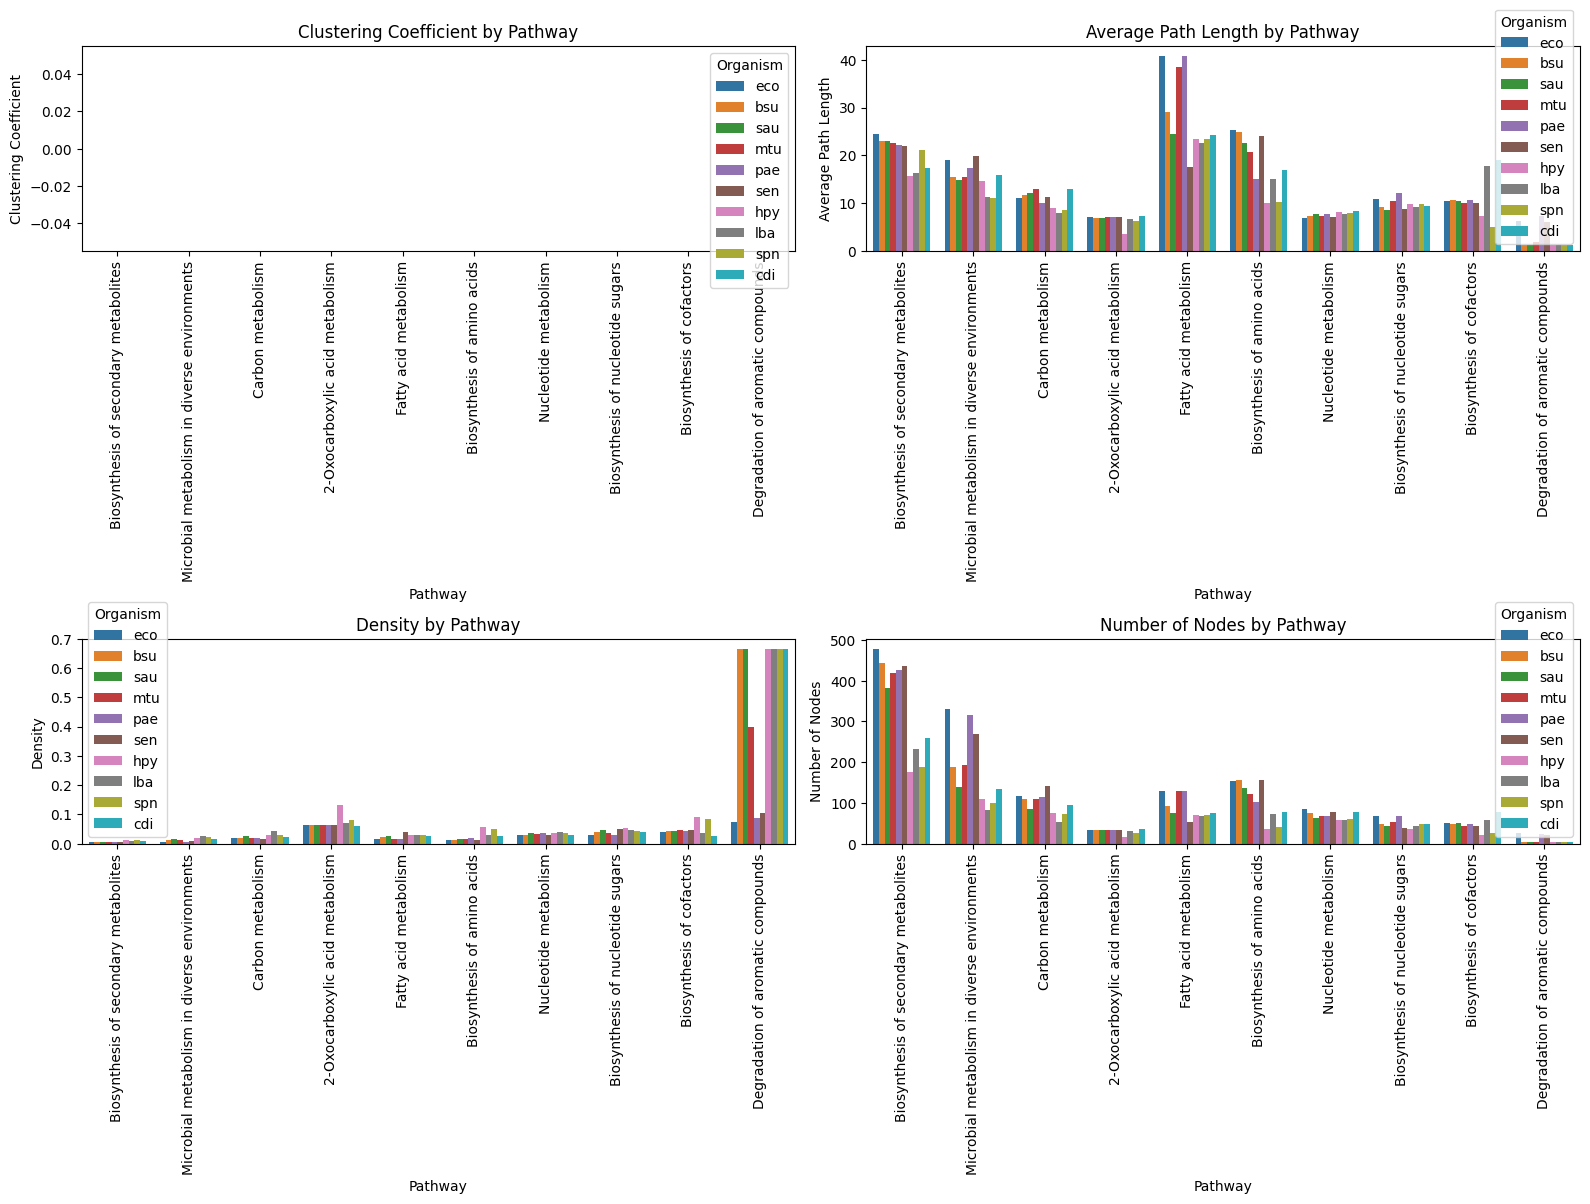

In [154]:
# Setting up the figure
plt.figure(figsize=(16, 12))

metrics = ['Clustering Coefficient', 'Average Path Length', 'Density', 'Number of Nodes']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Pathway', y=metric, hue='Organism', data=individual_network_metrics, ci=None)
    plt.title(f'{metric} by Pathway')
    plt.xticks(rotation=90)
    plt.ylabel(metric)
    plt.xlabel('Pathway')

plt.tight_layout()
plt.show()

### Overall network metrics

In [63]:
network_metrics.head()

,Organism,Clustering Coefficient,Average Path Length,Density,Number of Nodes
0,eco,0.0,24.992221,0.001775,1261
0,bsu,0.0,24.641192,0.002125,1040
0,sau,0.0,24.269118,0.002534,865
0,mtu,0.0,28.065926,0.002315,953
0,pae,0.0,24.655114,0.001720,1279


In [75]:
metrics = list(network_metrics.columns)
print(metrics)

['Organism', 'Clustering Coefficient', 'Average Path Length', 'Density', 'Number of Nodes']


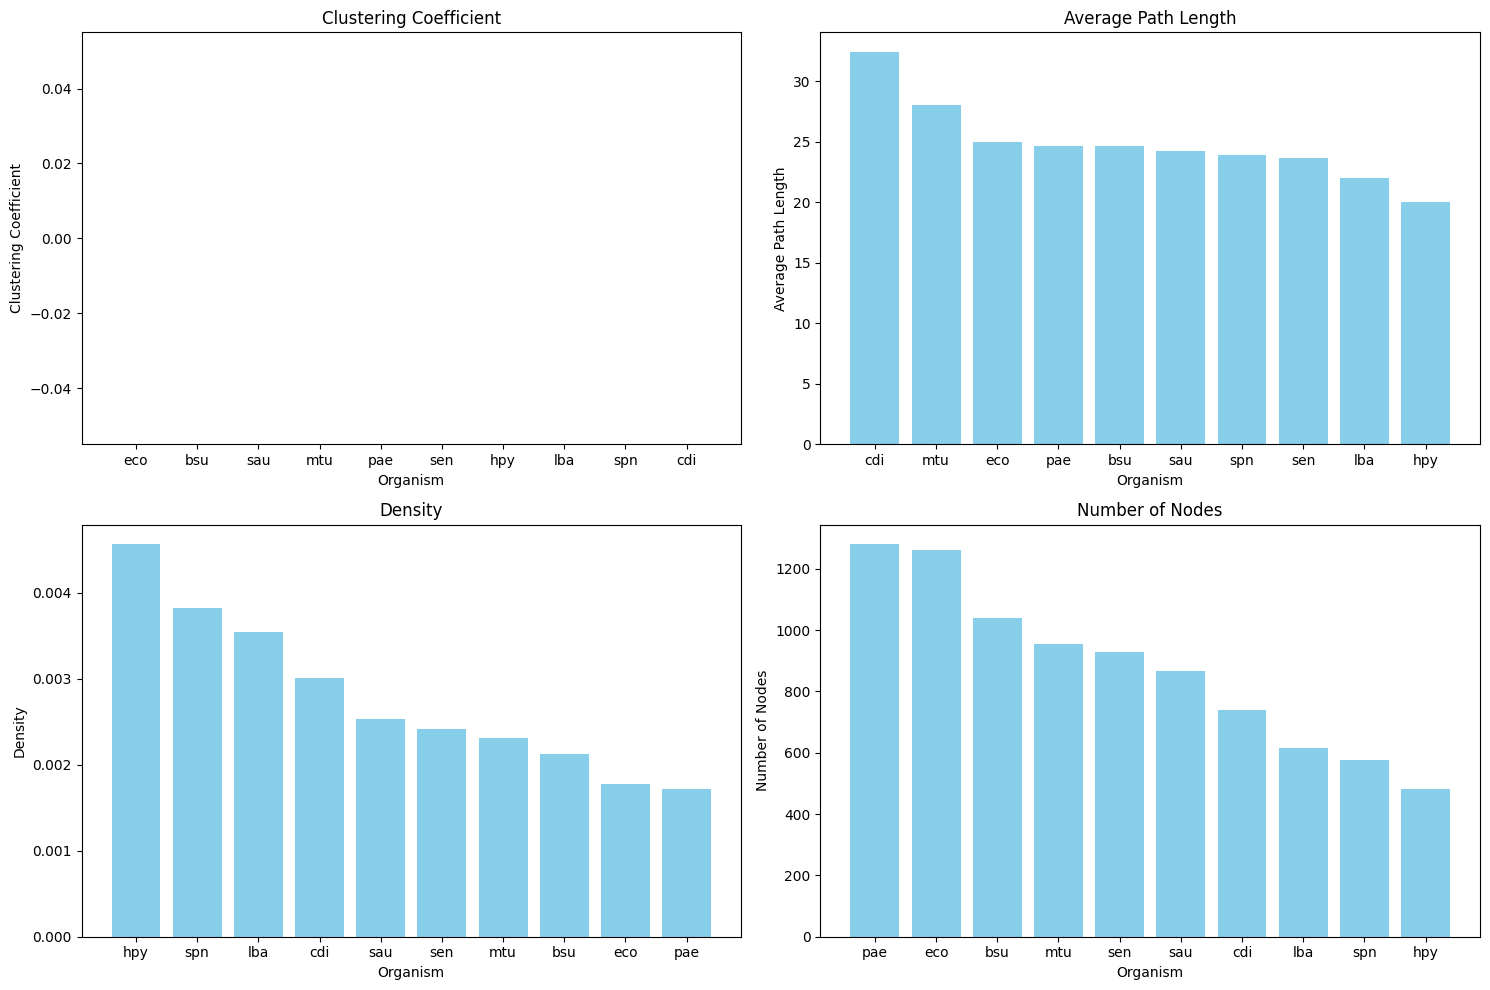

In [77]:
# Plotting each metric separately
metrics = ['Clustering Coefficient', 'Average Path Length', 'Density', 'Number of Nodes']

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    sorted_df = network_metrics.sort_values(by=metric, ascending=False)
    
    plt.subplot(2, 2, i+1)
    plt.bar(sorted_df['Organism'], sorted_df[metric], color='skyblue')
    plt.title(metric)
    plt.xlabel('Organism')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

### node metrics

In [110]:
node_metrics = pd.read_csv('metrics/overall_node_metrics.csv')

In [135]:
grouped_stats = network_metrics.groupby(['Organism', 'Pathway']).agg({
    'Degree Centrality': ['mean', 'max', 'min'],
    'Betweenness Centrality': ['mean', 'max', 'min'],
    'Closeness Centrality': ['mean', 'max', 'min'],
    'Eigenvector Centrality': ['mean', 'max', 'min']
}).reset_index()

grouped_stats

Organism                                       Pathway Degree Centrality  \
                                                                      mean   
0      eco               2-Oxocarboxylic acid metabolism          0.001546   
1      eco                   Biosynthesis of amino acids          0.002041   
2      eco                     Biosynthesis of cofactors          0.001797   
3      eco             Biosynthesis of nucleotide sugars          0.001597   
4      eco         Biosynthesis of secondary metabolites          0.001545   
5      eco                             Carbon metabolism          0.001997   
6      eco             Degradation of aromatic compounds          0.002237   
7      eco                         Fatty acid metabolism          0.001636   
8      eco  Microbial metabolism in diverse environments          0.001533   
9      eco                         Nucleotide metabolism          0.001960   

                      Betweenness Centrality                 \
        max       min                   mean       max  min   
0  0.003968  0.000794               0.005103  0.076081  0.0   
1  0.008730  0.000794               0.030286  0.282367  0.0   
2  0.008730  0.000794               0.023078  0.217655  0.0   
3  0.003175  0.000794               0.008047  0.050962  0.0   
4  0.003968  0.000794               0.013109  0.222130  0.0   
5  0.004762  0.000794               0.019200  0.190026  0.0   
6  0.010317  0.000794               0.030313  0.414344  0.0   
7  0.006349  0.000794               0.034942  0.161533  0.0   
8  0.003175  0.000794               0.006153  0.047192  0.0   
9  0.005556  0.000794               0.007293  0.113417  0.0   

  Closeness Centrality                     Eigenvector Centrality  \
                  mean       max       min                   mean   
0             0.051215  0.069814  0.033947           9.453243e-04   
1             0.050028  0.071154  0.027710           1.511551e-02   
2             0.040310  0.065089  0.022779           2.337101e-03   
3             0.045187  0.062627  0.036086           6.499566e-03   
4             0.043827  0.069907  0.026966           3.934746e-03   
5             0.060014  0.070842  0.047929           1.731808e-02   
6             0.051479  0.072501  0.033206           3.503148e-03   
7             0.034915  0.068639  0.014382           2.200191e-04   
8             0.049082  0.069399  0.023374           2.234242e-03   
9             0.032546  0.038462  0.025959           6.209407e-11   

                               
            max           min  
0  1.656033e-02  8.004043e-13  
1  3.729727e-01  1.899167e-16  
2  2.976942e-01  4.442438e-20  
3  1.514319e-01  4.913740e-09  
4  2.701851e-01  4.818251e-17  
5  2.116229e-01  1.002081e-06  
6  6.127815e-02  1.261170e-12  
7  1.104527e-02  2.444388e-21  
8  6.654216e-02  1.485343e-19  
9  3.694591e-10  3.204098e-14

In [126]:
grouped_stats = node_metrics.groupby(['Organism']).agg({
    'Degree Centrality': ['mean', 'max', 'min'],
    'Betweenness Centrality': ['mean', 'max', 'min'],
    'Closeness Centrality': ['mean', 'max', 'min'],
    'Eigenvector Centrality': ['mean', 'max', 'min']
}).reset_index()

grouped_stats

Organism Degree Centrality                     Betweenness Centrality  \
                        mean       max       min                   mean   
0      bsu          0.002125  0.010587  0.000962               0.022776   
1      cdi          0.003007  0.013550  0.001355               0.042629   
2      eco          0.001775  0.010317  0.000794               0.019057   
3      hpy          0.004563  0.016632  0.002079               0.039553   
4      lba          0.003543  0.013029  0.001629               0.034279   
5      mtu          0.002315  0.012605  0.001050               0.028460   
6      pae          0.001720  0.010955  0.000782               0.018524   
7      sau          0.002534  0.011574  0.001157               0.026963   
8      sen          0.002417  0.011853  0.001078               0.024468   
9      spn          0.003830  0.015679  0.001742               0.040026   

                 Closeness Centrality                      \
        max  min                 mean       max       min   
0  0.374058  0.0             0.043735  0.072744  0.023157   
1  0.603054  0.0             0.034365  0.054687  0.012782   
2  0.414344  0.0             0.043722  0.072501  0.014382   
3  0.477316  0.0             0.054510  0.088713  0.026362   
4  0.521120  0.0             0.050042  0.081195  0.016937   
5  0.564737  0.0             0.039691  0.064381  0.012172   
6  0.423269  0.0             0.044240  0.073809  0.014545   
7  0.586601  0.0             0.044308  0.073632  0.023563   
8  0.362014  0.0             0.046360  0.073319  0.021055   
9  0.551250  0.0             0.045555  0.072256  0.021876   

  Eigenvector Centrality                          
                    mean       max           min  
0               0.005601  0.371700  3.304986e-13  
1               0.007395  0.379253  2.342203e-12  
2               0.004952  0.372973  2.444388e-21  
3               0.011044  0.382298  8.749779e-12  
4               0.009803  0.405479  1.445571e-14  
5               0.005975  0.377222  6.180708e-17  
6               0.004770  0.371082  9.472704e-20  
7               0.006139  0.382596  2.355911e-12  
8               0.006173  0.373914  4.361369e-18  
9               0.010382  0.415694  4.255237e-13

In [134]:
grouped_eco = grouped_stats[node_metrics['Organism'] == 'eco']
grouped_eco

C:\Users\dylan\AppData\Local\Temp\ipykernel_46164\3978669361.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped_eco = grouped_stats[node_metrics['Organism'] == 'eco']


Organism                                       Pathway Degree Centrality  \
                                                                       mean   
0       bsu               2-Oxocarboxylic acid metabolism          0.001867   
1       bsu                   Biosynthesis of amino acids          0.002465   
2       bsu                     Biosynthesis of cofactors          0.002199   
3       bsu             Biosynthesis of nucleotide sugars          0.001972   
4       bsu         Biosynthesis of secondary metabolites          0.001833   
..      ...                                           ...               ...   
88      spn         Biosynthesis of secondary metabolites          0.003361   
89      spn                             Carbon metabolism          0.003702   
90      spn                         Fatty acid metabolism          0.003611   
91      spn  Microbial metabolism in diverse environments          0.003039   
92      spn                         Nucleotide metabolism          0.003787   

                       Betweenness Centrality                 \
         max       min                   mean       max  min   
0   0.003850  0.000962               0.009440  0.175614  0.0   
1   0.008662  0.000962               0.035697  0.374058  0.0   
2   0.010587  0.000962               0.030676  0.229268  0.0   
3   0.003850  0.000962               0.010672  0.056879  0.0   
4   0.004812  0.000962               0.016107  0.248247  0.0   
..       ...       ...                    ...       ...  ...   
88  0.006969  0.001742               0.068955  0.272014  0.0   
89  0.008711  0.001742               0.043363  0.380060  0.0   
90  0.010453  0.001742               0.044879  0.350355  0.0   
91  0.005226  0.001742               0.006824  0.059711  0.0   
92  0.010453  0.001742               0.013832  0.092976  0.0   

   Closeness Centrality                     Eigenvector Centrality  \
                   mean       max       min                   mean   
0              0.047168  0.069971  0.027863           2.568648e-04   
1              0.049042  0.072744  0.027375           1.509466e-02   
2              0.042231  0.068145  0.023282           3.798806e-03   
3              0.045421  0.059293  0.036013           6.604375e-03   
4              0.042193  0.070407  0.026395           3.856041e-03   
..                  ...       ...       ...                    ...   
88             0.045355  0.066114  0.025705           4.592688e-03   
89             0.060010  0.071580  0.051665           2.756121e-02   
90             0.039355  0.064969  0.023950           3.314192e-05   
91             0.055645  0.067849  0.039842           9.277477e-03   
92             0.030632  0.040727  0.023884           9.681908e-08   

                                
             max           min  
0   6.853329e-03  4.609560e-12  
1   3.717001e-01  2.270742e-12  
2   3.267448e-01  4.130912e-13  
3   6.993478e-02  4.666689e-09  
4   2.690634e-01  5.404513e-12  
..           ...           ...  
88  2.373977e-01  6.632961e-11  
89  1.544855e-01  2.679762e-05  
90  1.327139e-03  4.255237e-13  
91  1.164946e-01  2.484035e-07  
92  8.174976e-07  1.254459e-09  

[93 rows x 14 columns]

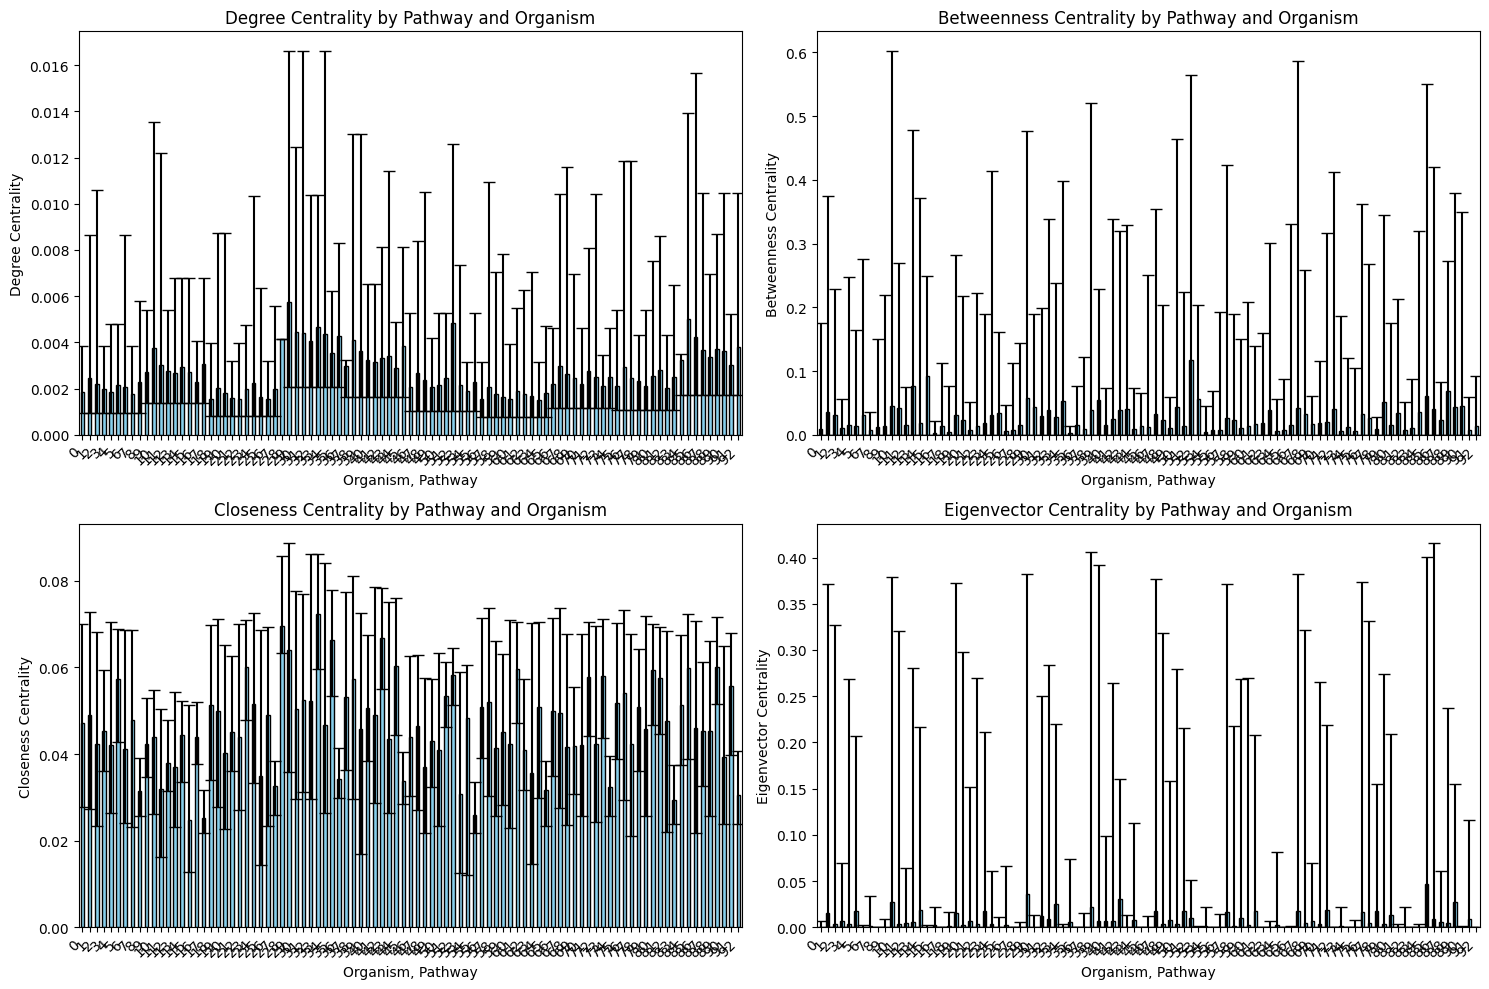

In [132]:
df = grouped_stats


metrics = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    # Extract data for the current metric
    means = df[(metric, 'mean')]
    mins = df[(metric, 'min')]
    maxs = df[(metric, 'max')]
    
    # Calculate error bars
    errors = [means - mins, maxs - means]
    
    # Plot with error bars
    means.plot(kind='bar', yerr=errors, capsize=4, ax=plt.gca(), color='skyblue', edgecolor='black')
    plt.title(f'{metric} by Pathway and Organism')
    plt.xlabel('Organism, Pathway')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()